In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import RandomizedSearchCV


from sklearn.svm import SVC

import shap

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from math import sqrt

np.random.seed(42)

# Autism Screening

## Dataset Utilizzati

- https://archive.ics.uci.edu/ml/datasets/Autism+Screening+Adult

- https://archive.ics.uci.edu/ml/datasets/Autistic+Spectrum+Disorder+Screening+Data+for+Children++

Note: i due dataset fanno riferimento allo stesso studio ma si differenziano per l'età dei partecipanti.

I due datast sono stati convertiti dal formato `.arff` al formato `.csv` usando [questa libreria](https://github.com/Hutdris/arff2csv)

# Analisi dei dati

All'interno di queta sezione verranno analizzati i dati scaricati dal database UCI, verra' preso in considerazione il dataset composto dall'unione dei due specifici

In [2]:
child = pd.read_csv('Autism-Child-Data.csv')
adult = pd.read_csv('Autism-Adult-Data.csv')
complete = pd.concat([child, adult])

## Analisi delle feature
Per prima cosa viene effettuata una analisi delle feature presenti nel dataset

In [3]:
complete.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

In [4]:
child.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

In [5]:
adult.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

- A*_Score -> indica la risposta data ad una domanda del test, una feature per ogni domanda del test
    contiene un valore booleano che indica se la risposta fornita è stat positiva o negativa.
- age -> eta' del soggetto
- gender -> sesso del soggetto
- ethnicity -> etnia del soggetto
- jundice -> presenza di itterizia alla nascita (condizione molto comune negli USA, il neonato presenta una colorazione gialla/verde della pelle, della sclera e delle mucose a cuasa di un innalzamento dei livelli di Bilirubina nel sangue)
- autism -> indica se un parente diretto e' stato diagnosticato PDD (_Pervasive developemental distorder_, uno dei tipi dello spettro autistico, definito dal DSM-IV come "severo e pervasimo impedimento nello sviluppo delle relazioni interpersonali o nella comunicazione verbale e non verbale")
- country_of_res -> paese di residenza
- used_app_before -> indica se il test era stato eseguito in precedenza
- result -> numero di risposte affermative date
- age_desc -> età discretizzata in infante e adulto
- relation -> relazione che intercorre tra il soggetto e il somministratore del test
- cass/ASD -> diagnosi, __classe da predire__

## Pulizia dei dati

Dopo avere definito i dati con cui si sta lavorando si procede con la pulizia, iniziando rimuovendo eventuali duplicati

In [6]:
print(complete.shape)
complete = complete.drop_duplicates(keep = 'first')
print(complete.shape)

(996, 21)
(989, 21)


Dopo avere rimosso i duplicati si procede con una analisi per determinare la presenza di eventuali valori nulli

In [7]:
complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 703
Data columns (total 21 columns):
A1_Score           989 non-null int64
A2_Score           989 non-null int64
A3_Score           989 non-null int64
A4_Score           989 non-null int64
A5_Score           989 non-null int64
A6_Score           989 non-null int64
A7_Score           989 non-null int64
A8_Score           989 non-null int64
A9_Score           989 non-null int64
A10_Score          989 non-null int64
age                989 non-null object
gender             989 non-null object
ethnicity          989 non-null object
jundice            989 non-null object
austim             989 non-null object
contry_of_res      989 non-null object
used_app_before    989 non-null object
result             989 non-null int64
age_desc           989 non-null object
relation           989 non-null object
Class/ASD          989 non-null object
dtypes: int64(11), object(10)
memory usage: 170.0+ KB


I tipi dei dati sono:

In [8]:
complete.dtypes

A1_Score            int64
A2_Score            int64
A3_Score            int64
A4_Score            int64
A5_Score            int64
A6_Score            int64
A7_Score            int64
A8_Score            int64
A9_Score            int64
A10_Score           int64
age                object
gender             object
ethnicity          object
jundice            object
austim             object
contry_of_res      object
used_app_before    object
result              int64
age_desc           object
relation           object
Class/ASD          object
dtype: object

dato che le colonne dele risposte dei semplici valori binari è possibile convertire gli `int64` in `int8`

In [9]:
for question in complete.columns[0:10]:
    child[question] = child[question].astype('int8')
    adult[question] = adult[question].astype('int8')
    complete[question] = complete[question].astype('int8')


Lo stesso discorso vale per result, essendo il numero delle risposte positive date è necessario un int8 per memorizzare tutti i posisbili valori

In [10]:
child['result'] = child['result'].astype('int8')
adult['result'] = adult['result'].astype('int8')
complete['result'] = complete['result'].astype('int8')

L'età viene memorizzata come stringa, interessante analizzare i diversi valori che contiene per capirne il motivo:

In [11]:
complete['age'].value_counts()

4      91
21     49
20     46
5      44
6      39
22     37
23     37
19     35
24     34
27     31
30     30
18     29
26     28
29     27
7      27
11     26
25     26
28     24
8      21
31     21
9      20
17     18
10     18
32     18
37     17
35     17
40     16
33     16
42     15
36     13
38     12
34     12
43     11
44      9
47      7
39      7
55      6
53      6
46      6
?       6
52      5
50      5
45      4
48      4
41      3
49      3
54      2
61      2
56      2
58      2
51      1
60      1
383     1
59      1
64      1
Name: age, dtype: int64

Nell'elenco dei valori è possibile notare sia valori nulli, indicati con `?` ed un valore palesemente errato: `383`.
I valori mancanti indicati con `?` possono essere sostiuti con il valore medio del gruppo di età a cui fanno riferimento, discorso analogoper i valori errati.
Si consierano errati di valori di età superiori a 110.

In [12]:
complete['age'] = pd.to_numeric(complete['age'], errors='coerce')
complete.loc[complete.age > 110, 'age'] = np.nan

In [13]:
complete.loc[complete.age_desc == "'4-11 years'", 'age'] = complete.loc[complete.age_desc == "'4-11 years'", 'age'].fillna(complete.loc[complete.age_desc == "'4-11 years'", 'age'].mean())

In [14]:
complete.loc[complete.age_desc != "'4-11 years'", 'age'] = complete.loc[complete.age_desc != "'4-11 years'", 'age'].fillna(complete.loc[complete.age_desc != "'4-11 years'", 'age'].mean())

In [15]:
complete['age'].isna().sum()

0

In [16]:
complete['age'] = complete['age'].astype('int8')

Visto l'alto numero di parametri di tipo categorico `catboost` è un ottimo modello candidato dato che è stato pensato appoistamente per questo tipo di dati.
Per usare modelli che non gestiscono in modo nativo feature categoriche sarà necessario usare metodi come `one hot encoding` per convertire le stringhe in numeri.

Probabilmente anche le altre feature categoriche presentano valori nulli ma si decide di non intervenire in modo da dare la possibilità ai modelli scelti di intervnire in modo autonomo. Questo è reso possibile anche dal datto che i modellis scelti permettono di gestire in modo nativo i valori mancanti.

## Visualizzazione dei dati

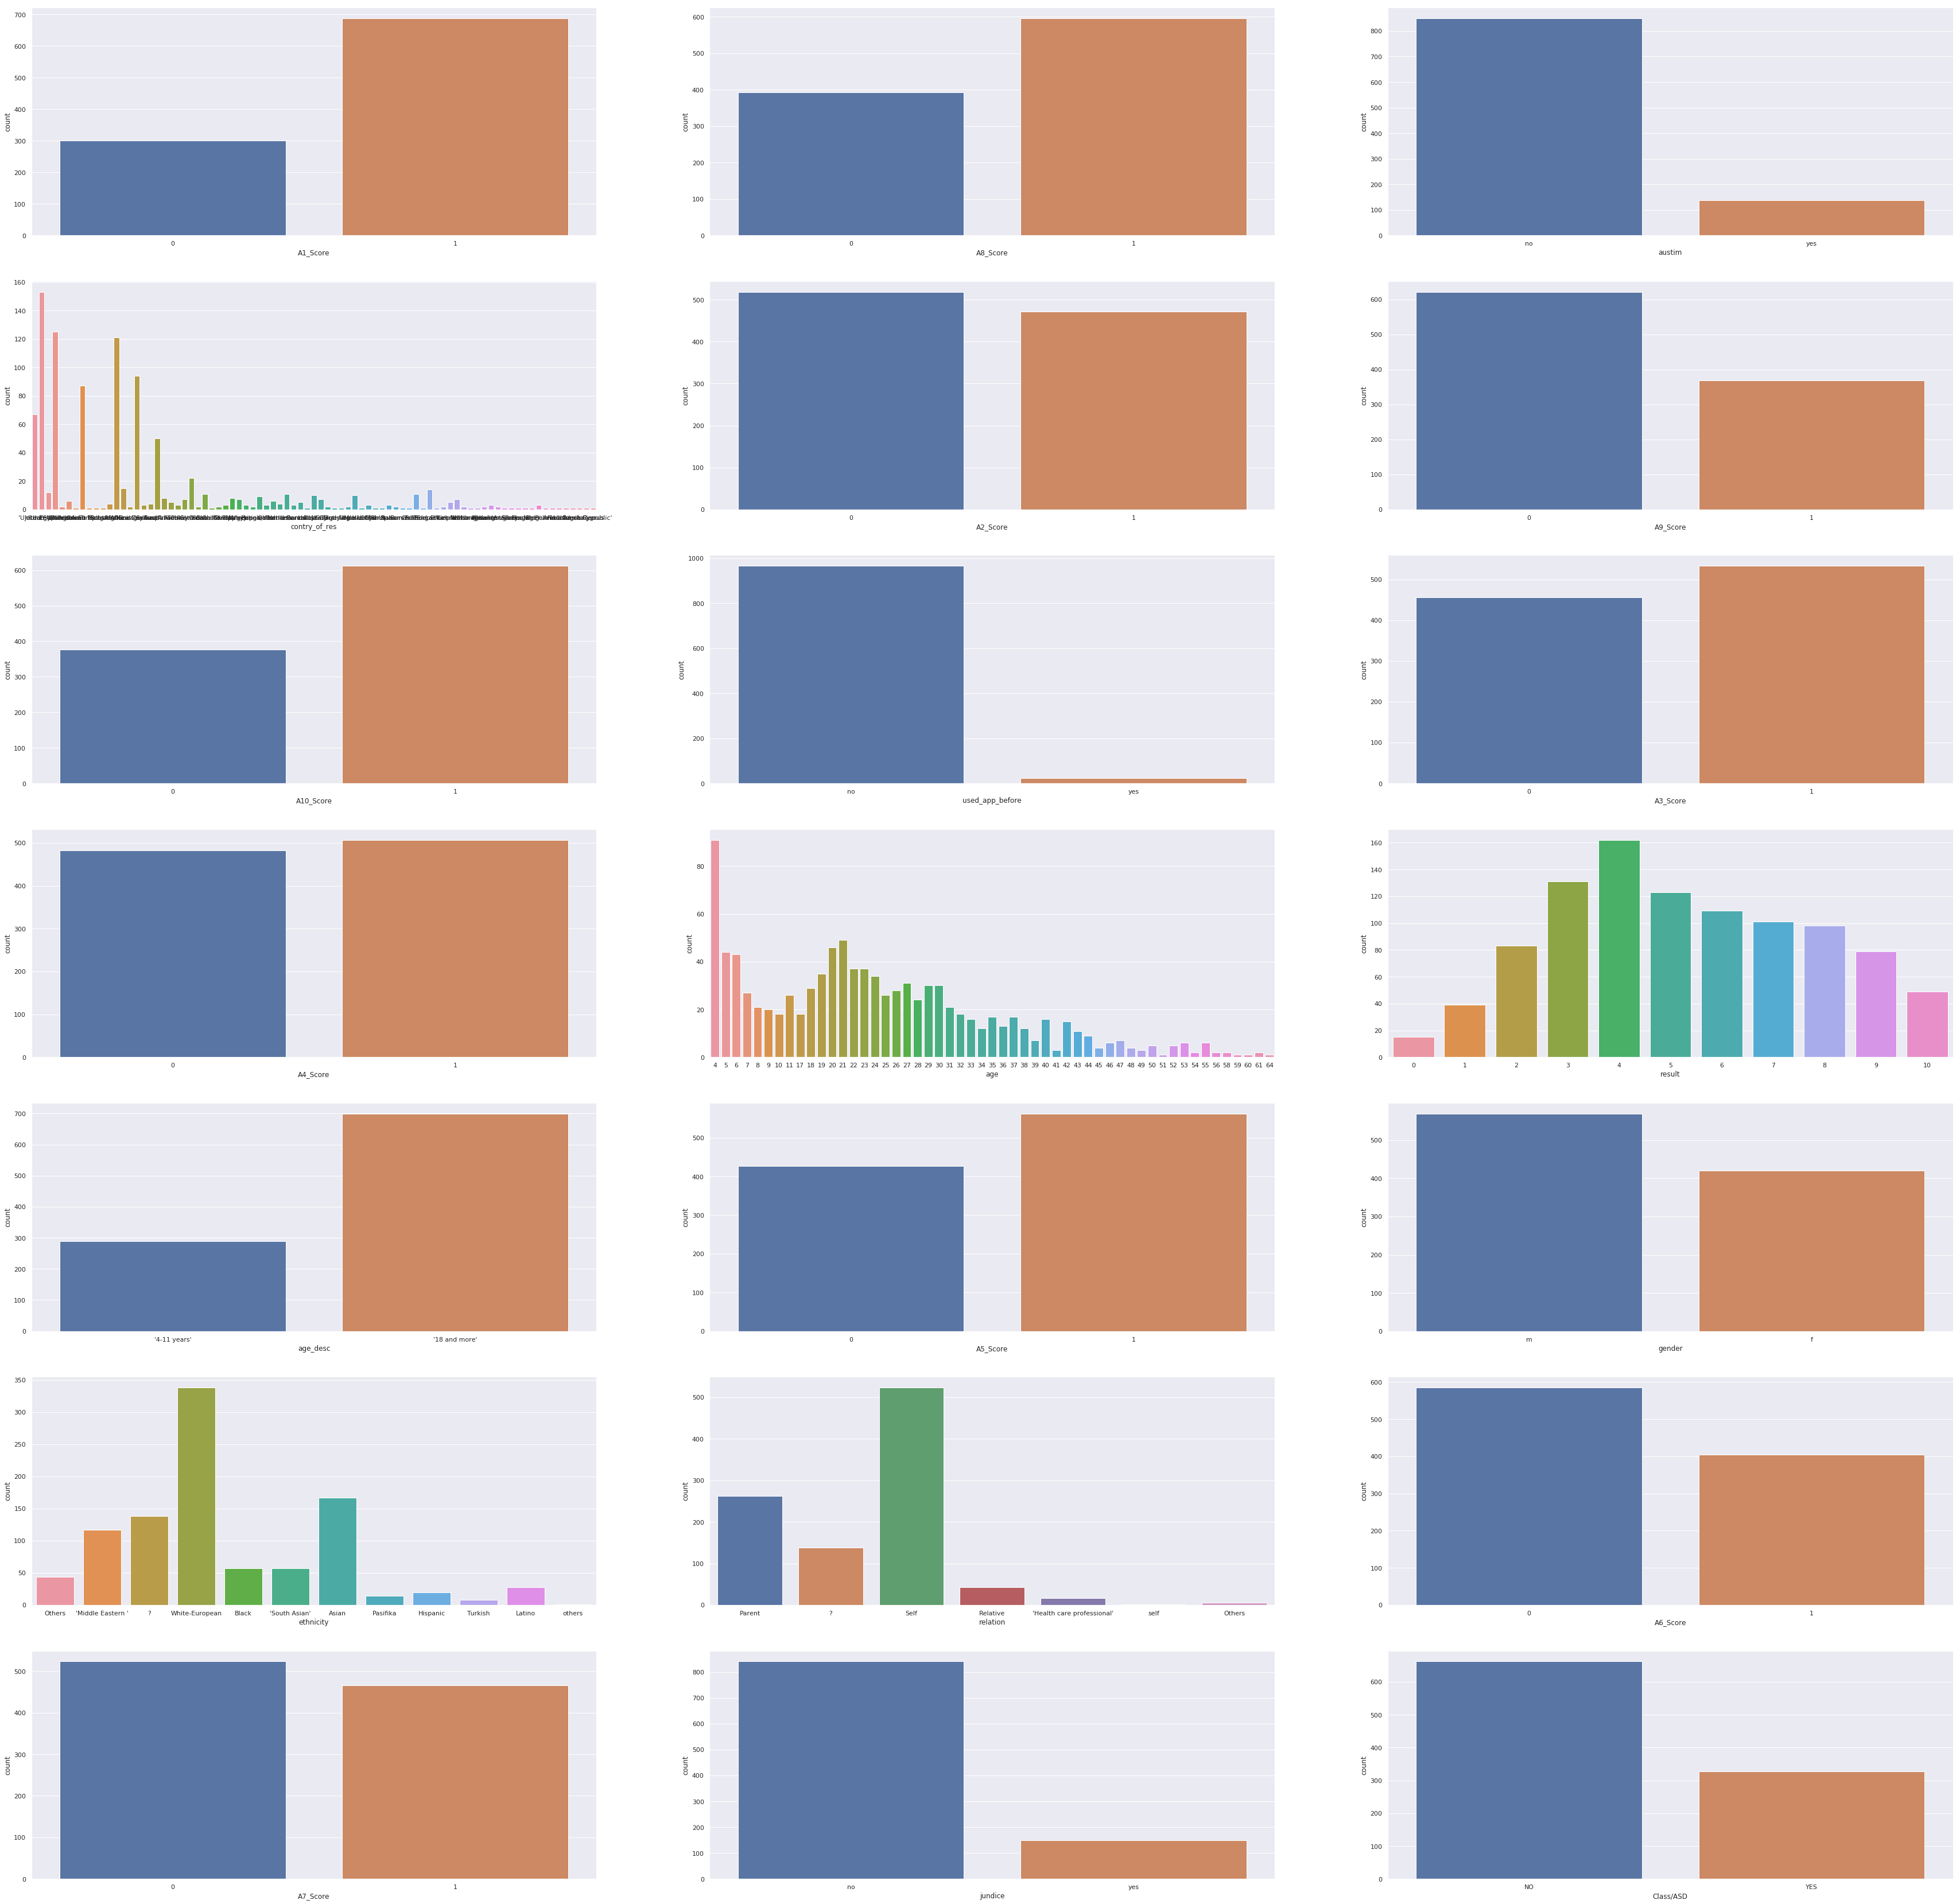

In [17]:
fig, axarr = plt.subplots(7, 3, figsize = (60, 60))


for i, column in enumerate(complete.columns):
    plt.sca(axarr[i % 7, i % 3])
    sns.countplot(x = column, data = complete)

plt.show()

Osservano i grafici è anche possibile notare che per le feature `relation` e `ethnics` è presente sia l'attributo `self` che l'attributo `Self`, pertanto occorre convertire tutto nello stesso case 

In [18]:
complete['relation']  = complete['relation'].str.lower()
complete['ethnicity']  = complete['ethnicity'].str.lower()

Una criticità che emerge dal grafico è l'alto numero di diversi valori per la feature `contry_of_res`, usare un _one-hot-encoding_ in questo contesto potrebbe portare ad una esplosione del numero delle feature.

Si procede con contare il numero dei diversi valori che assumono le diverse feature.

In [19]:
for column in complete.columns:
    print('{}: {}'.format(column, len(set(complete[column]))))

A1_Score: 2
A2_Score: 2
A3_Score: 2
A4_Score: 2
A5_Score: 2
A6_Score: 2
A7_Score: 2
A8_Score: 2
A9_Score: 2
A10_Score: 2
age: 53
gender: 2
ethnicity: 11
jundice: 2
austim: 2
contry_of_res: 83
used_app_before: 2
result: 11
age_desc: 2
relation: 6
Class/ASD: 2


In [20]:
complete.loc[complete.age_desc == '4-11 years']

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD


## Analisi ASD e Itterizia

Text(0.5, 0, 'Itterizzia alla nascita')

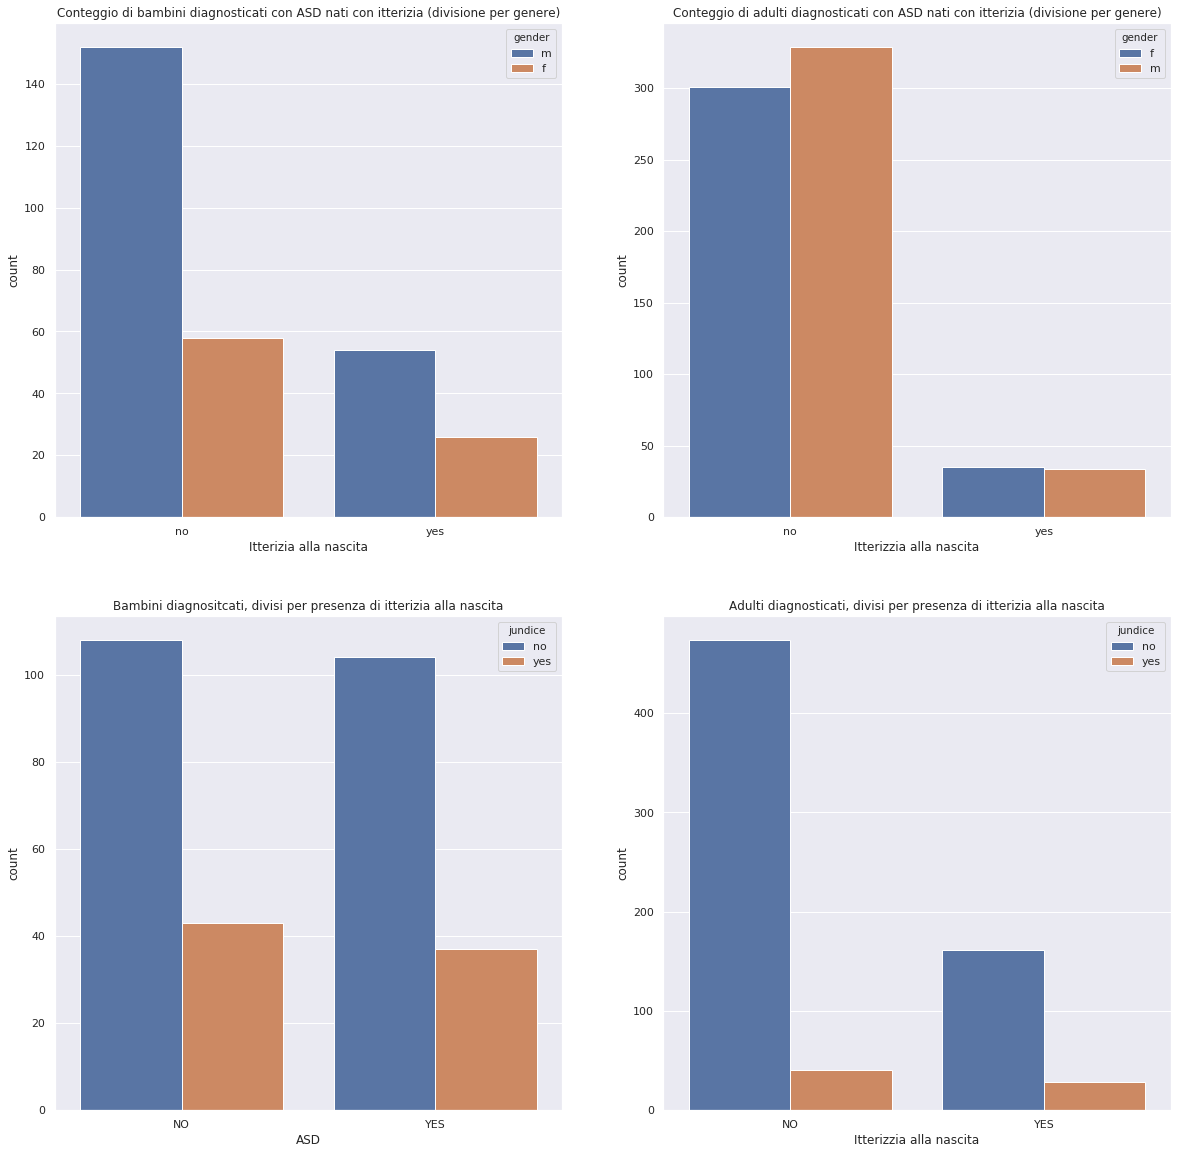

In [21]:
data1 = complete.loc[complete.age_desc == "'4-11 years'"]
data2 = complete.loc[complete.age_desc != "'4-11 years'"]

fig, ax = plt.subplots(2,2,figsize=(20,20))

sns.countplot(x='jundice',data=data1,hue='gender',ax=ax[0,0])
ax[0,0].set_title('Conteggio di bambini diagnosticati con ASD nati con itterizia (divisione per genere)')
ax[0,0].set_xlabel('Itterizia alla nascita')

sns.countplot(x='jundice',data=data2,hue='gender',ax=ax[0,1])
ax[0,1].set_title('Conteggio di adulti diagnosticati con ASD nati con itterizia (divisione per genere)')
ax[0,1].set_xlabel('Itterizzia alla nascita')

sns.countplot(x='Class/ASD',data=child,hue='jundice',ax=ax[1,0])
ax[1,0].set_title('Bambini diagnositcati, divisi per presenza di itterizia alla nascita')
ax[1,0].set_xlabel('ASD')

sns.countplot(x='Class/ASD',data=adult ,hue='jundice',ax=ax[1,1])
ax[1,1].set_title('Adulti diagnosticati, divisi per presenza di itterizia alla nascita')
ax[1,1].set_xlabel('Itterizzia alla nascita')

## Analisi ASD ed età

Text(0.5, 1.0, 'Distribuzione delle diagnosi di ASD per età')

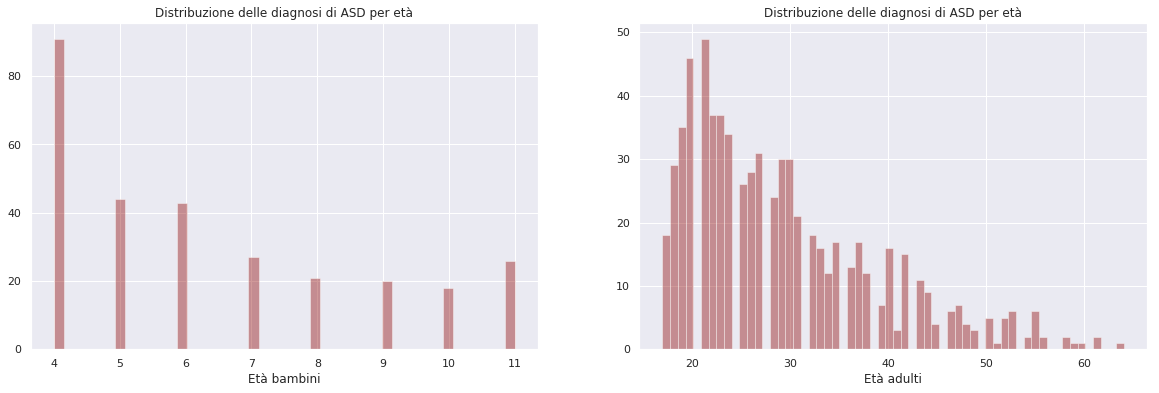

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
sns.distplot(data1['age'],kde=False,bins=45,color='darkred',ax=ax[0])
ax[0].set_xlabel('Età bambini')
ax[0].set_title('Distribuzione delle diagnosi di ASD per età')

sns.distplot(data2['age'],kde=False,bins=60,color='darkred',ax=ax[1])
ax[1].set_xlabel('Età adulti')
ax[1].set_title('Distribuzione delle diagnosi di ASD per età')

## Analisi a livello di entia e famigliare

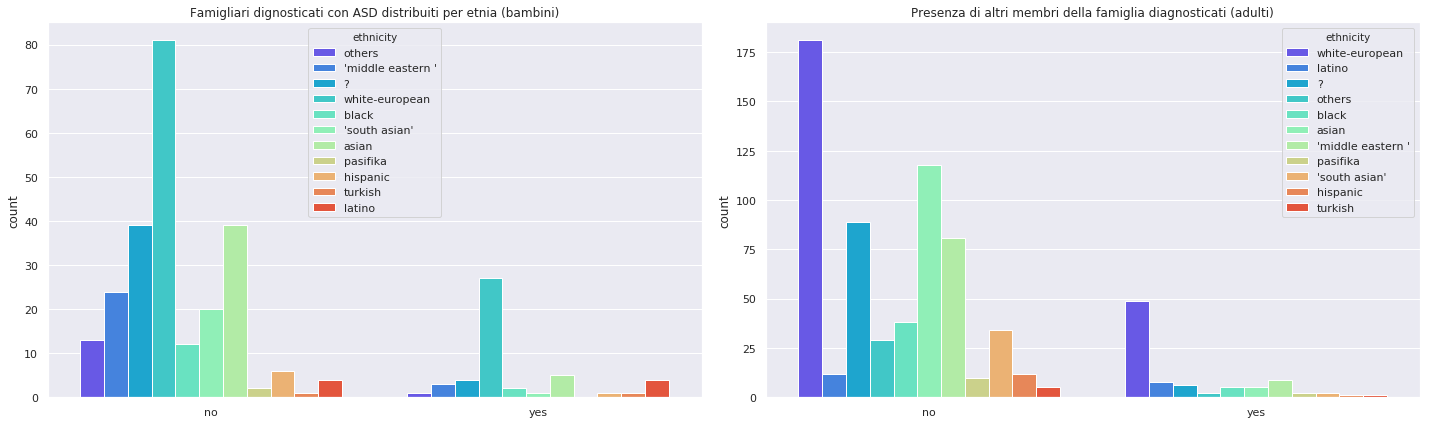

In [23]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
sns.countplot(x='austim',data=data1,hue='ethnicity',palette='rainbow',ax=ax[0])
ax[0].set_title("Famigliari dignosticati con ASD distribuiti per etnia (bambini)")
ax[0].set_xlabel('')

sns.countplot(x='austim',data=data2,hue='ethnicity',palette='rainbow',ax=ax[1])
ax[1].set_title('Presenza di altri membri della famiglia diagnosticati (adulti)')
ax[1].set_xlabel('')
plt.tight_layout()

## Feature engeneering
Si decide di non sfruttare la feature che rappresenza la città di residenza data l'elevato numero di possibili valori che può assumere.
Dato che alcuni modelli, come catboost, possono gestire senza bisogno di encoding i dati categorici verranno effettuati di confronti per determinare se questa feature svolte un ruolo determinate o meno all'interno del modello.

In [24]:
complete.drop('contry_of_res', inplace=True, axis = 1)

Prima di proseguire con le modifiche al dataset viene eseguita una copia del dataset compelto di partenza

In [25]:
complete_copy = complete.copy()

Per le altre feature vengono introdotte delle feature ottenute mediante `one_hot_encoding` per potere rappresentare i dati in modo numerico, queste operazioni vengono svolte su una copia del dataset compelto in modo da potere eseguire dei test sfruttando anche modelli basati su dati categorici.


In [26]:
male=pd.get_dummies(complete['gender'],drop_first=True)
ethnics=pd.get_dummies(complete['ethnicity'],drop_first=True)
jaundice=pd.get_dummies(complete['jundice'],drop_first=True)
ASD_genes=pd.get_dummies(complete['austim'],drop_first=True)
used_app_before = pd.get_dummies(complete['used_app_before'], drop_first=True)
relation = pd.get_dummies(complete['relation'], drop_first=True)
age_desc = pd.get_dummies(complete['age_desc'], drop_first=True)

encoded = pd.concat([male, ethnics, jaundice, ASD_genes, used_app_before, relation, age_desc], axis = 1)

In [27]:
encoded.columns=['male','South Asian','?','Asian','Black','Hispanic','Latino','Others_ethnics','Pasifika','Tuekish','White-European','Jaundice','ASD_relatives', 'Used_app_before', 'relation_?', 'relation_other', 'relation_parent', 'relation_relative', 'relation_self', 'child']

In [28]:
complete.drop('gender', axis = 1, inplace=True)
complete.drop('ethnicity', axis = 1, inplace=True)
complete.drop('jundice', axis = 1, inplace=True)
complete.drop('austim', axis = 1, inplace=True)
complete.drop('used_app_before', axis = 1, inplace=True)
complete.drop('relation', axis = 1, inplace=True)
complete.drop('age_desc', axis = 1, inplace=True)

In [29]:
complete_concat = pd.concat([encoded, complete], axis = 1)

---

# Modellazione

In questa sezione verranno descritti a grandi linee i modelli adoperati e la natura del problema.

Il problema può essere affrontato come un problema di classificazione multivariata, verranno utilizzati vari modelli e risultati confrontati.

I modelli in esame saranno:

- random forest
- xgboost
- catboost
- SVM

## Aspetti teorici dei modelli

Vista la natura medica e sociale del problema affrontato ho preferito usare modelli piu' facilmente interpretabili rispetto alla reti neurali in modo che a posteriori si possano ottenere informazioni sulle feature che maggiormante hanno paetecipato alla "scoperta" dell'informazione

### Random forest

Le random forest sono un esempio di algoritmo di learning basato sulla tecnicva dell'ensable, un processo che consiste nell'unire le predizioni fornite da modelli "deboli" per avere una predizione maggiormante accurata, nel caso di radom forest i modelli che vengono assemblati sono degli alberi di decisione.

Lo scopo di una random foreset, come suggerisce il nome, e' introdurre dei gradi di casualita' all'interno del modello, nello specifico:

- ogni albero viene addestrato con un sottoinsieme casuale delle righe
- le feature indagate per eseguire uno split all'interno del nodo di un albero sono un subset casuale di tutte le feature a disposizione

Queste decisioni portano ad avere alberi molto diversi tra di loro essendo creati in modo completamente indipendente

Questo tipo di modello gestisce in modo efficace eventuali valori mancanti ed e' meno predisposto all'overfitting vista l'intrinseca casualita' che lo contraddistingue, di contro ,a causa dell'elevato numero di alberi che formano il modello, e' difficile applicare il modello a situazioni real-time.

### xgboost

XGBoost e' una implementazione di una tecnica chiamata _gradient boosting decision tree_, un approccio simile a quello usato da random forest ma in cui ogni albero viene addestrato in modo che sia capace di correggere gli errori compiuti dal suo predecessore.


### catboost

Catboost e' libreria basata sul concetto di gradient boosting prodotta da Yandex con lo scopo ottimizare predizioni in cui le variabili di tipo categorico prevalgono.

Adotta un approccio per il quale ogni valore delle feature categoriche viene sostituita con una statica legata al valore della label


### voting

Dopo avere addestrato i modelli elencati in precedenza verra' creato anche un modello basato sulla votazione all'interno del quale gli altri modelli saranno chiamati ad esprimere una votazione per determinare l'esito della classificazione



## Implementazione


Prima di tutto verra' effettuata una divisione in train e test set

In [30]:
train_size = 0.7

X_enc = complete_concat.drop(columns = ['Class/ASD'])
y_enc = complete_concat['Class/ASD']
y_enc = (y_enc == 'YES').astype('int8')

X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, train_size = train_size, stratify = y_enc)

X = complete_copy.drop(columns=['Class/ASD'])
y = complete_concat['Class/ASD']
y = (y == 'YES').astype('int8')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size, stratify = y)

Questa divisione tra train e test rimarra' invariata nei confronti tra i vari modelli in modo che il confronto tra di essi non dipenda dai dati

# Test senza result

Dato che result dipende linearmente dalle risposte date non viene consiì

In [31]:
models_noResEtn = []

In [32]:
X_enc_noRes = X_enc.drop(['result'], axis = 1)
X_train_enc_noRes = X_train_enc.drop(['result'], axis = 1)
X_test_enc_noRes = X_test_enc.drop(['result'], axis = 1)

In [56]:
models = {'random forest': RandomForestClassifier(n_estimators=1000),
         'xgb':  XGBClassifier(n_estimators=1000),
         'cat encoded':  CatBoostClassifier(n_estimators=1000, verbose = False),
         }

random forest
[[195   4]
 [  5  93]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       199
           1       0.96      0.95      0.95        98

    accuracy                           0.97       297
   macro avg       0.97      0.96      0.97       297
weighted avg       0.97      0.97      0.97       297



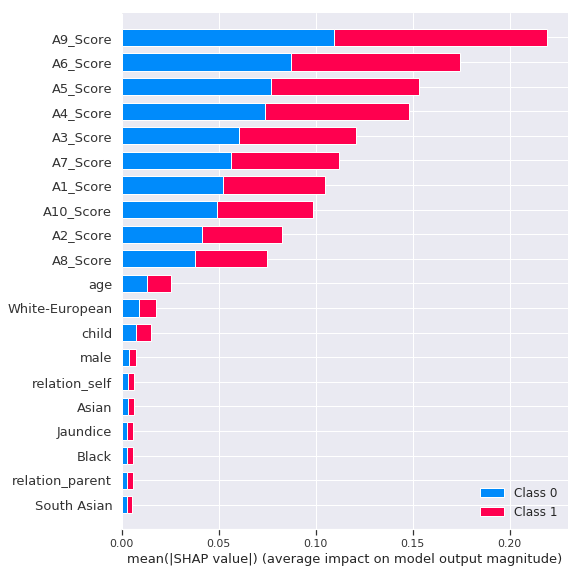

xgb
[[197   2]
 [  2  96]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       199
           1       0.98      0.98      0.98        98

    accuracy                           0.99       297
   macro avg       0.98      0.98      0.98       297
weighted avg       0.99      0.99      0.99       297



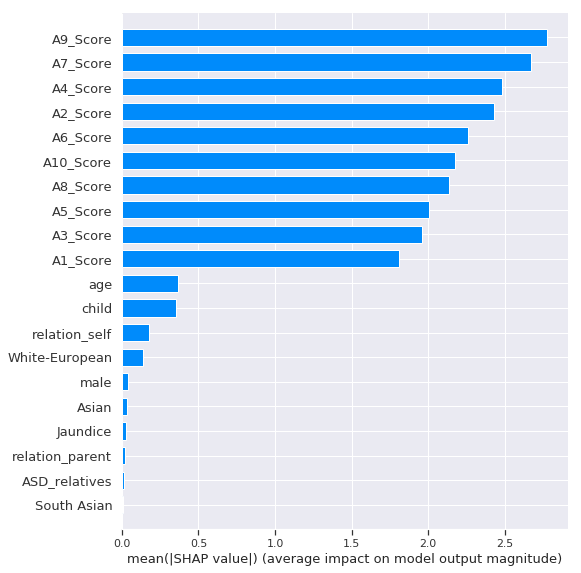

cat encoded
[[198   1]
 [  2  96]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       199
           1       0.99      0.98      0.98        98

    accuracy                           0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297



/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/catboost/core.py:1697: UserWarning: 'fstr_type' parameter will be deprecated soon, use 'type' parameter instead
  warnings.warn("'fstr_type' parameter will be deprecated soon, use 'type' parameter instead")


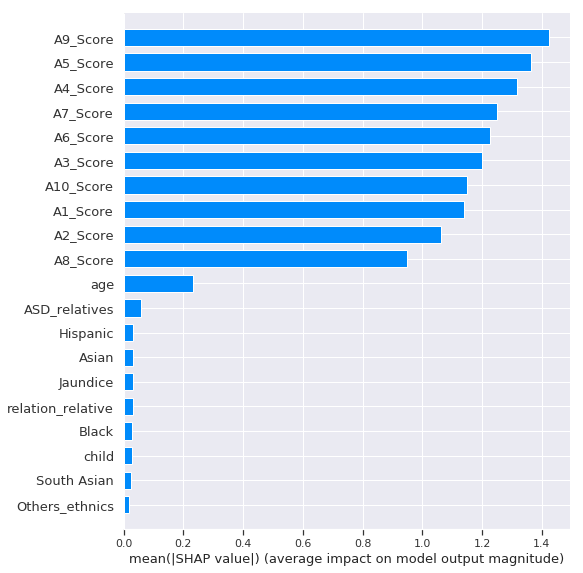

In [57]:
for name, model in models.items():
    print(name)
    model.fit(X_train_enc_noRes, y_train_enc)
    predictions = model.predict(X_test_enc_noRes)
    print(confusion_matrix(y_test_enc, predictions))
    print(classification_report(y_test_enc,predictions))
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_enc_noRes)
    shap.summary_plot(shap_values, X_enc_noRes, plot_type='bar')

In [58]:
estimators = []
for name, model in models.items():
    estimators.append((name, model))
voting = VotingClassifier(estimators=estimators, voting = 'soft')

In [59]:
voting.fit(X_train_enc_noRes, y_train_enc)
predictions = voting.predict(X_test_enc_noRes)
print(confusion_matrix(y_test_enc, predictions))
print(classification_report(y_test_enc,predictions))

[[198   1]
 [  2  96]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       199
           1       0.99      0.98      0.98        98

    accuracy                           0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297



# Tunig Parametri con random search

## random forest

In [63]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [5, 10, 30, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 3, 5, 10, 12, 20],
 'n_estimators': [800, 1000, 1200, 1600, 1800]}




rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, n_iter = 150, cv = 5, verbose = False, random_state=42, n_jobs = -1)



rf_random.fit(X_train_enc_noRes, y_train_enc)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

## xgboost

In [64]:
grid_xgboost = {
    'n_estimators' : [100, 500, 1000, 1200, 1500],
    'learning_rate': [0.0001, 0.00001, 0.01, 0.001,0.05],
    'max_depth': [3, 4, 5, 6, 10, 12, 15, 20],
    "min_child_weight" : [ 5, 7, 10, 12, 13],
    "gamma"            : [ 0.0, 0.001, 0.02, 0.1, 0.2 , 0.3],
    "colsample_bytree" : [0.02, 0.01, 0.3, 0.4, 0.5 , 0.7 ]
}



xgb_rand = RandomizedSearchCV(XGBClassifier(), grid_xgboost, cv = 5, n_jobs=-1, verbose = False, n_iter = 150)
xgb_rand.fit(X_train_enc_noRes, y_train_enc)

/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale...
                   param_distributions={'colsample_bytree': [0.02, 0.01, 0.3,
                                                             0.4, 0.5, 0.7],
                                        'gamma': [0.0, 0.001, 0.02

## catboost

In [107]:
grid_catbost =  {
    'depth':[3,1,2,6,4,5,7,8],
    'iterations':[250,100,500,1000, 1500, 200, 300],
    'learning_rate':[0.03,0.001,0.0001,0.0001,0.01],
    'l2_leaf_reg':[3,1,5,10],
    'border_count':[50, 100,200, 300]
}

cat_search = RandomizedSearchCV(CatBoostClassifier(verbose = False), grid_catbost, cv = 5, n_jobs=-1, verbose = False, n_iter=150)
cat_search.fit(X_train_enc_noRes, y_train_enc)

/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/jobli

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fc242cee5f8>,
                   iid='warn', n_iter=150, n_jobs=-1,
                   param_distributions={'border_count': [50, 100, 200, 300],
                                        'depth': [3, 1, 2, 6, 4, 5, 7, 8],
                                        'iterations': [250, 100, 500, 1000,
                                                       1500, 200, 300],
                                        'l2_leaf_reg': [3, 1, 5, 10],
                                        'learning_rate': [0.03, 0.001, 0.0001,
                                                          0.0001, 0.01]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=False)

In [74]:
models = {'random forest': RandomForestClassifier(**rf_random.best_params_),
         'xgb':  XGBClassifier(**xgb_rand.best_params_),
         'cat encoded':  CatBoostClassifier(**cat_search.best_params_, verbose=False),
         }

random forest
[[195   4]
 [  7  91]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       199
           1       0.96      0.93      0.94        98

    accuracy                           0.96       297
   macro avg       0.96      0.95      0.96       297
weighted avg       0.96      0.96      0.96       297



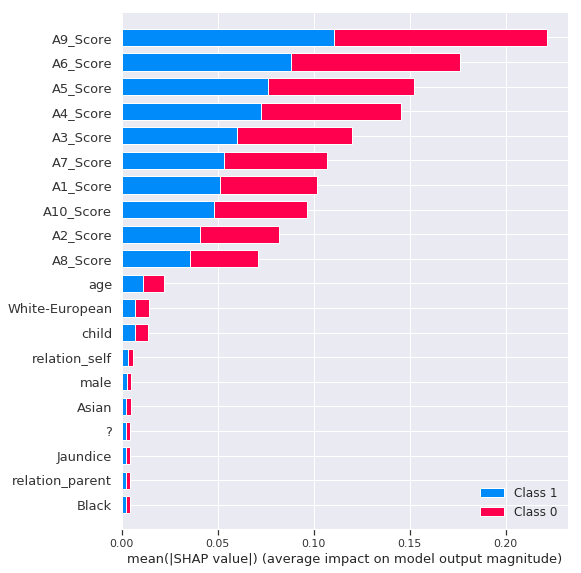

xgb
[[198   1]
 [  1  97]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       199
           1       0.99      0.99      0.99        98

    accuracy                           0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297



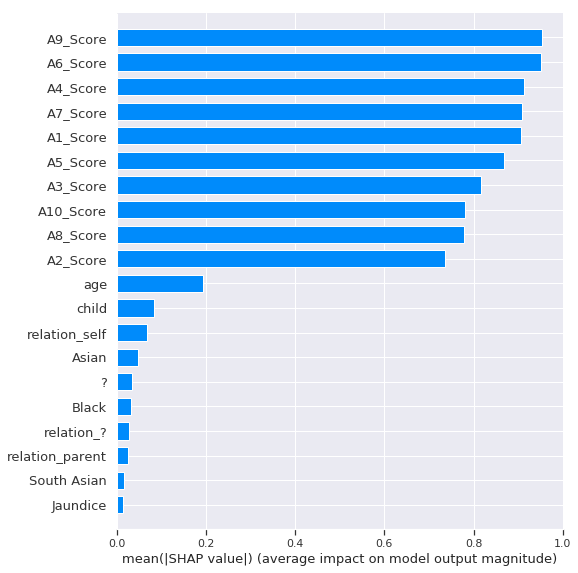

cat encoded
[[199   0]
 [  0  98]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       199
           1       1.00      1.00      1.00        98

    accuracy                           1.00       297
   macro avg       1.00      1.00      1.00       297
weighted avg       1.00      1.00      1.00       297



/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/catboost/core.py:1697: UserWarning: 'fstr_type' parameter will be deprecated soon, use 'type' parameter instead
  warnings.warn("'fstr_type' parameter will be deprecated soon, use 'type' parameter instead")


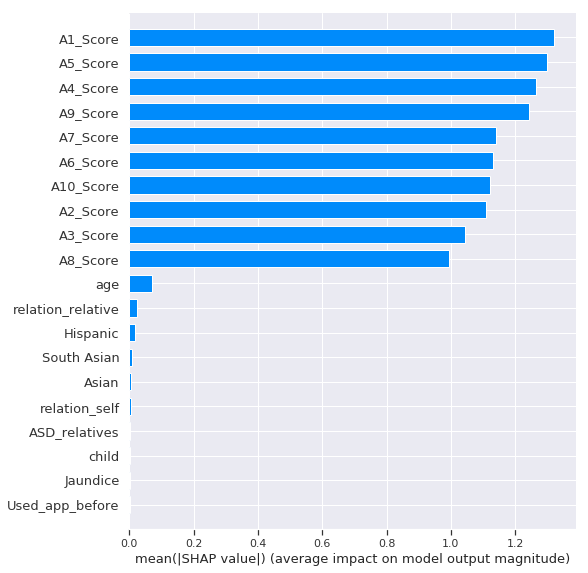

In [75]:
for name, model in models.items():
    print(name)
    model.fit(X_train_enc_noRes, y_train_enc)
    predictions = model.predict(X_test_enc_noRes)
    print(confusion_matrix(y_test_enc, predictions))
    print(classification_report(y_test_enc,predictions))
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_enc_noRes)
    shap.summary_plot(shap_values, X_enc_noRes, plot_type='bar')

In [76]:
estimators = []
for name, model in models.items():
    estimators.append((name, model))
voting = VotingClassifier(estimators=estimators, voting = 'soft')

In [77]:
voting.fit(X_train_enc_noRes, y_train_enc)
predictions = voting.predict(X_test_enc_noRes)
print(confusion_matrix(y_test_enc, predictions))
print(classification_report(y_test_enc,predictions))

[[199   0]
 [  0  98]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       199
           1       1.00      1.00      1.00        98

    accuracy                           1.00       297
   macro avg       1.00      1.00      1.00       297
weighted avg       1.00      1.00      1.00       297



# Calcolo intervallo di confidenza del modello finale

Il calcolo dell'intervanno di confidenza dell'accuratezza e' necessario per determianre quanto, a livello statistico, il nostro modello e' effettivamente efficacie.
Per determianre l'intervallo e' necessario fissare un confidenza in modo da determinare, sfruttando il teorema del limite centrale, un intervallo che contenga la reale accuratezza del modello con un certo intervallo di confidenza.

In [106]:
from statsmodels.stats.proportion import proportion_confint
lower, upper = proportion_confint(accuracy_score(y_test_enc, predictions) * len(y_test_enc), len(y_test_enc), 0.01)
print('lower=%.3f, upper=%.3f' % (lower, upper))

lower=1.000, upper=1.000


Dopo questo test è possibile affermare che la possibilità che l'accuratezza del modello sia del 100% con il 99.9% di confidenza.